# Clusters of Orthologous Genes (COGs) and their Properties

This notebook contains visualizations of analyses constructed from the main COG mapping file. All code used to generate these outputs (and commented functions) is located at ```/afs/cs.stanford.edu/u/manans/Desktop/graph-embeddings/cog-tests/cog.py```.

In [1]:
import numpy as np

import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 12)
plt.ion()

## Intra-Species Analysis

In order to determine how protiens are inter-related within a single species, a matrix was constructed for the sample species with NCBI ID 10141, in which each index consisted of the number of orthologous groups that the two proteins shared. More precisely, $$M_{ij} = M_{ji} = \mathbf{card}(\text{COG}_i \cap \text{COG}_j)$$ where $\text{COG}_x$ is the set of orthologous groups that contain protein $x$. Proteins not included in any orthologous group are represented by the null set $\emptyset$, and their intersection with themselves (along the diagonal) is counted as 0.

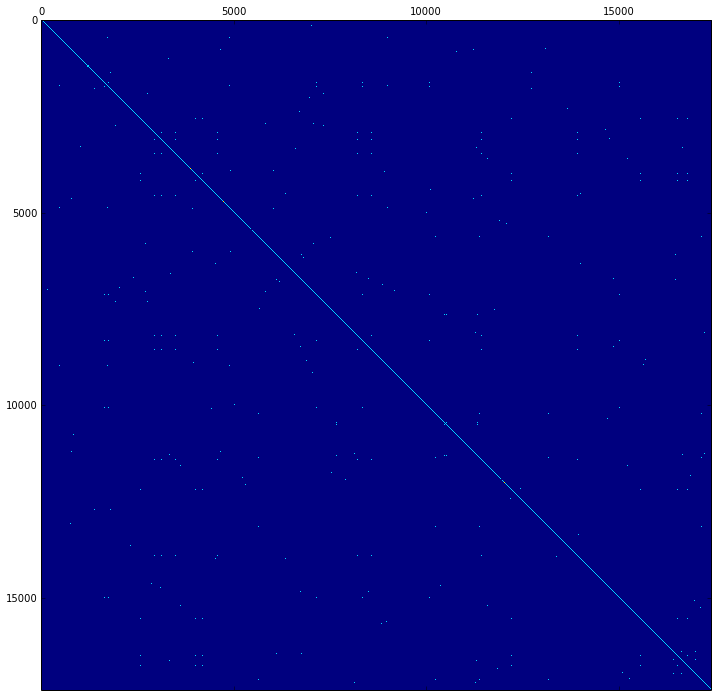

In [2]:
intra_species_10141 = np.load('/dfs/scratch0/manans/10141.npz')
plt.matshow(intra_species_10141, aspect='auto')

## Inter-Species Analysis

In order to determine the relationships of different species based on the COGs that their proteins share, a matrix was constructed both for a small subset of 100 species (of dimension $100 \times 100$) and for the entire set of 2,031 species (of dimension $2031 \times 2031$). Specifically, we have $$M_{ij} = M_{ji} = \textbf{card} \left( \bigcup_{n=1}^{N_i}\text{COG}_{n} \cap \bigcup_{m=1}^{N_j}\text{COG}_{m} \right) $$ where $N_i$ and $N_j$ are the number of proteins in species $i$ and $j$, respectively. All diagonals are artificially set to 0 so that the variances in other (more instructive) interactions can be more readily observed.

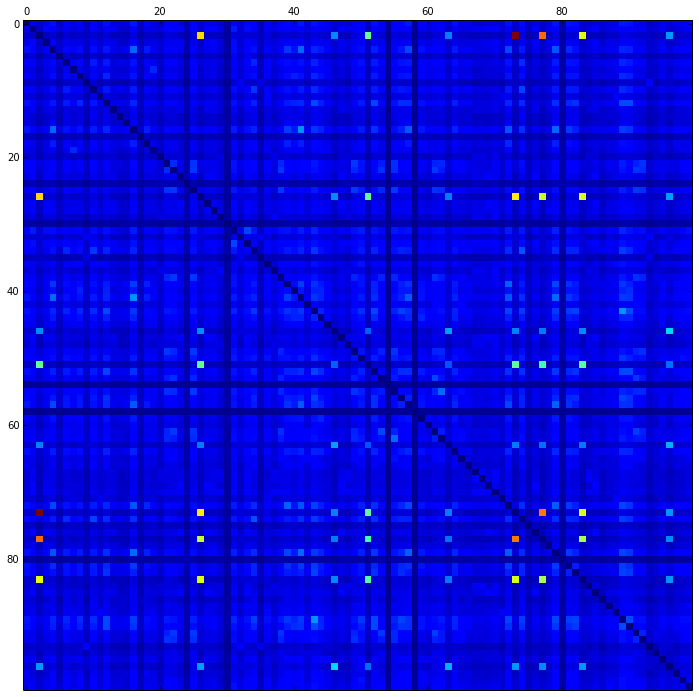

In [5]:
inter_species_100 = np.load('/dfs/scratch0/manans/inter_species_100.npz')

for (i, j), z in np.ndenumerate(inter_species_100):
    if i == j:
        inter_species_100[i][j] = 0
plt.matshow(inter_species_100, aspect='auto')

# For numerical visualization
# for (i, j), z in np.ndenumerate(matrix1):
#    plt.text(j, i, str(int(z)), ha='center', va='center')

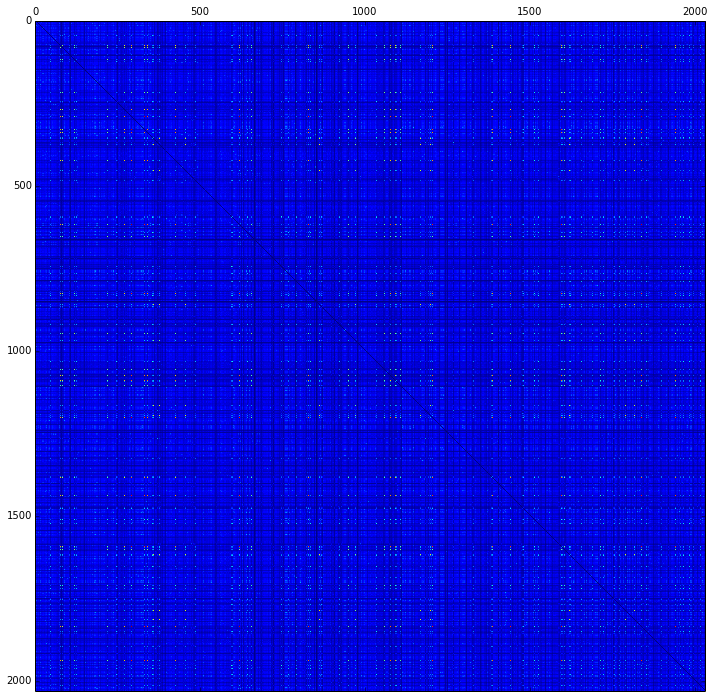

In [6]:
inter_species_2031 = np.load('/dfs/scratch0/manans/inter_species_2031.npz')
for (i, j), z in np.ndenumerate(inter_species_2031):
    if i == j:
        inter_species_2031[i][j] = 0
plt.matshow(inter_species_2031, aspect='auto')

## Matrix Clustering and Prediction

Now that we've obtained a matrix of interactions between all 2,031 species, we can treat each row as a feature vector for its corresponding species (that is, species $i$ is represented by feature vector $M[i][:]$). These vectors are clustered via KMeans into three groups to provide representation for the three domains Bacteria, Archaea, and Eukaryota, and the clusters are evaluated for discriminatory potential. 

In [7]:
from sklearn.cluster import KMeans

# 3 clusters to ideally separate archaea, bacteria, and eukarya
kmeans = KMeans(n_clusters=3, random_state=0).fit(inter_species_2031)
labels = kmeans.predict(inter_species_2031)

# row_dict represents the true IDs of the rows
row_dict = np.load('/dfs/scratch0/manans/inter_species_2031_labels.npz')

In [8]:
clusters = {}
n = 0
for item in labels:
    if item in clusters:
        clusters[item].append(row_dict[n])
    else:
        clusters[item] = [row_dict[n]]
    n +=1

print len(clusters[0]), len(clusters[1]), len(clusters[2])

845 209 977


The NCBITaxa SQL database is used to obtain the lineage for any particular ID and identify the domain associated with the ID. 

In [9]:
from ete2 import NCBITaxa
ncbi = NCBITaxa('/dfs/scratch0/manans/.etetoolkit/taxa.sqlite')

def id_to_domain(id_str):
    lineage = ncbi.get_lineage(id_str)
    try:
        domain_map = ncbi.get_taxid_translator([lineage[2]])
        return domain_map[lineage[2]]
    except:
        domain_map = ncbi.get_taxid_translator([lineage[0]])
        return domain_map[lineage[0]]

In [10]:
cluster_mapping = [[0, 0, 0], [0, 0, 0], [0, 0, 0]]

for item in clusters:
    print "Cluster ", item
    for i in clusters[item]:
        domain = id_to_domain(str(i))
        if domain == 'Bacteria':
            cluster_mapping[item][0] += 1
        elif domain == 'Archaea':
            cluster_mapping[item][1] += 1
        elif domain == 'Eukaryota':
            cluster_mapping[item][2] += 1

Cluster  0
Cluster  1
Cluster  2


In [12]:
cm = np.array(cluster_mapping)
cm

array([[698, 114,  29],
       [  0,   0, 206],
       [977,   0,   0]])

As seen above, the Eukaryota class seems to be significantly (and easily) differentiated from the Bacteria and Archaea classes, but the distinctions between Bacteria and Archaea are quite hard to identify. 

## Viability of Only Considering COG-Linked Proteins in Species

Finally, we considered the feasiblity of only analyzing COG-linked proteins (CLPs) when making predictions about species. For each species, protein $i$ was designated a CLP if $\textbf{card}(\text{COG}_i) > 0$. 

In [45]:
import pandas as pd

cog_table = pd.read_csv('/dfs/scratch0/manans/cog_table.txt', sep ='\t', header = 0, 
                        names = ["Species ID", "# CLPs", "# Proteins", "%CLPs"])
cog_table

,Species ID,# CLPs,# Proteins,%CLPs
0,272563,3333,3698,0.901298
1,10090,19871,20648,0.962369
2,340099,2106,2230,0.944395
3,316275,3346,3753,0.891553
4,699184,1454,2126,0.683913
5,573065,2919,3425,0.852263
6,290512,2097,2249,0.932414
7,582744,2509,2805,0.894474
8,547558,1899,1973,0.962494
9,314256,3460,3745,0.923899


In [44]:
print cog_table["# CLPs"].mean(), cog_table["# Proteins"].mean(), cog_table["%CLPs"].mean()

3603.49852217 4065.18472906 0.862479417084


Based on this simple analysis, it seems that analyzing only CLPs would not provide a significant benefit over analyzing a random subset of proteins. 